In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

2024-08-26 23:06:54.520287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 23:06:54.536974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 23:06:54.542123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 23:06:54.555055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 23:06:55.238850: W tensorflow/compiler/tf2

In [4]:
trainselffeats = np.load('data/trainselffeats.npy')
trainselfaddfeats = np.load('data/trainselfaddfeats.npy')
trainselflabels = np.load('data/trainselflabels.npy')
testfeats = np.load('data/testfeats.npy')
testaddfeats = np.load('data/testaddfeats.npy')
testselflabels = np.load('data/testselflabels.npy')


# Define NN1
class NN1(tf.keras.Model):
    def __init__(self):
        super(NN1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(640, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(3)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Define NN2
class NN2(tf.keras.Model):
    def __init__(self):
        super(NN2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

def predict(x1, x2):
    # Forward pass through NN1
    nn1_output = nn1(x1)
    
    # Combine NN1 output with additional features for NN2 input
    nn2_input = tf.concat([nn1_output, x2], axis=1)
    
    # Forward pass through NN2 to get the final prediction
    y_pred = nn2(nn2_input)
    
    return y_pred    

losstracker={}

# Instantiate the models
nn1 = NN1()
nn2 = NN2()

#dynamic learning rate
init_lr=0.01

# Optimizers
optimizer = tf.keras.optimizers.Adam()


# Loss function
loss_fn = tf.keras.losses.Huber()

# Training loop
epochs = 50000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        
        #dyn_lr=init_lr * 0.9995 ** epoch 
        #optimizer.learning_rate.assign(dyn_lr)
        
        # Forward pass through NN1
        nn1_output = nn1(trainselffeats)
        
        # Combine NN1 output with additional features for NN2 input
        nn2_input = tf.concat([nn1_output, trainselfaddfeats], axis=1)
        
        # Forward pass through NN2
        y_pred = nn2(nn2_input)
        
        # Calculate loss
        loss = loss_fn(trainselflabels, y_pred)
    
    # Compute gradients and apply updates
    gradients = tape.gradient(loss, nn1.trainable_variables + nn2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nn1.trainable_variables + nn2.trainable_variables))

    if (epoch+1)%10==0:
        predictions=predict(testfeats,testaddfeats)
        testloss=loss_fn(testselflabels, predictions)
        losstracker.update({epoch:math.log10(loss_fn(testselflabels, predictions))})
        if testloss>10**-3:
            optimizer.learning_rate.assign(0.01)
        elif testloss>10**-4:
            optimizer.learning_rate.assign(0.005)
        elif testloss>10**-5:
            optimizer.learning_rate.assign(0.001)
        elif testloss>10**-6:
            optimizer.learning_rate.assign(0.0005)
        elif testloss>10**-7:
            optimizer.learning_rate.assign(0.0001)
        elif testloss>10**-8:
            optimizer.learning_rate.assign(0.000001)
        
    if epoch%1000==0:
        nn1.save(f'models/self-density-nn1-{epoch}.h5')
        nn1.save_weights(f'models/self-density-nn1-{epoch}.weights.h5')
        nn2.save(f'models/self-density-nn2-{epoch}.h5')
        nn2.save_weights(f'models/self-density-nn2-{epoch}.weights.h5')
          
    # Print loss
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')



Epoch 1, Loss: 0.21363858878612518
Epoch 2, Loss: 0.18821805715560913
Epoch 3, Loss: 0.1646149903535843
Epoch 4, Loss: 0.14286035299301147
Epoch 5, Loss: 0.12296538800001144
Epoch 6, Loss: 0.10494757443666458
Epoch 7, Loss: 0.08881130814552307
Epoch 8, Loss: 0.07454919815063477
Epoch 9, Loss: 0.06212301552295685
Epoch 10, Loss: 0.051447462290525436
Epoch 11, Loss: 0.04239442199468613
Epoch 12, Loss: 0.02184646762907505
Epoch 13, Loss: 0.088862843811512
Epoch 14, Loss: 0.1503995954990387
Epoch 15, Loss: 0.163552924990654
Epoch 16, Loss: 0.13928328454494476
Epoch 17, Loss: 0.10067903250455856
Epoch 18, Loss: 0.0653608962893486
Epoch 19, Loss: 0.04018938168883324
Epoch 20, Loss: 0.024804990738630295
Epoch 21, Loss: 0.01684659719467163
Epoch 22, Loss: 0.014019309543073177
Epoch 23, Loss: 0.014314386993646622
Epoch 24, Loss: 0.01592738926410675
Epoch 25, Loss: 0.01747908629477024
Epoch 26, Loss: 0.018158849328756332
Epoch 27, Loss: 0.01762358471751213
Epoch 28, Loss: 0.015921398997306824
Ep

Epoch 997, Loss: 9.640979442337994e-06
Epoch 998, Loss: 9.632613910071086e-06
Epoch 999, Loss: 9.62426474870881e-06
Epoch 1000, Loss: 9.615924682293553e-06
Epoch 1001, Loss: 9.607598258298822e-06
Epoch 1002, Loss: 9.599270015314687e-06
Epoch 1003, Loss: 9.590949957782868e-06
Epoch 1004, Loss: 9.582643542671576e-06
Epoch 1005, Loss: 9.574343494023196e-06
Epoch 1006, Loss: 9.566048902343027e-06
Epoch 1007, Loss: 9.557763405609876e-06
Epoch 1008, Loss: 9.54948609432904e-06
Epoch 1009, Loss: 9.541219696984626e-06
Epoch 1010, Loss: 9.532959666103125e-06
Epoch 1011, Loss: 9.524706001684535e-06
Epoch 1012, Loss: 9.516464160697069e-06
Epoch 1013, Loss: 9.50822595768841e-06
Epoch 1014, Loss: 9.499998668616172e-06
Epoch 1015, Loss: 9.49177956499625e-06
Epoch 1016, Loss: 9.483567737333942e-06
Epoch 1017, Loss: 9.475361366639845e-06
Epoch 1018, Loss: 9.467167728871573e-06
Epoch 1019, Loss: 9.458977729082108e-06
Epoch 1020, Loss: 9.450797733734362e-06
Epoch 1021, Loss: 9.442625923838932e-06
Epoch 1

Epoch 1997, Loss: 4.791674655280076e-06
Epoch 1998, Loss: 4.789102604263462e-06
Epoch 1999, Loss: 4.786533281730954e-06
Epoch 2000, Loss: 4.783965323440498e-06
Epoch 2001, Loss: 4.781397365150042e-06
Epoch 2002, Loss: 4.778830771101639e-06
Epoch 2003, Loss: 4.776268724526744e-06
Epoch 2004, Loss: 4.773708042193903e-06
Epoch 2005, Loss: 4.771150088345166e-06
Epoch 2006, Loss: 4.768591225001728e-06
Epoch 2007, Loss: 4.7660382733738516e-06
Epoch 2008, Loss: 4.763486685988028e-06
Epoch 2009, Loss: 4.760932824865449e-06
Epoch 2010, Loss: 4.758382601721678e-06
Epoch 2011, Loss: 4.75583419756731e-06
Epoch 2012, Loss: 4.753292159875855e-06
Epoch 2013, Loss: 4.750743300974136e-06
Epoch 2014, Loss: 4.748197170556523e-06
Epoch 2015, Loss: 4.7456555876124185e-06
Epoch 2016, Loss: 4.743117642647121e-06
Epoch 2017, Loss: 4.740578333439771e-06
Epoch 2018, Loss: 4.738035841000965e-06
Epoch 2019, Loss: 4.735500624519773e-06
Epoch 2020, Loss: 4.7329663175332826e-06
Epoch 2021, Loss: 4.7304311010520905e-

Epoch 2997, Loss: 2.667654371180106e-06
Epoch 2998, Loss: 2.6659079139790265e-06
Epoch 2999, Loss: 2.664162366272649e-06
Epoch 3000, Loss: 2.662417273313622e-06
Epoch 3001, Loss: 2.6606724077282706e-06
Epoch 3002, Loss: 2.6589277695165947e-06
Epoch 3003, Loss: 2.6571851776679978e-06
Epoch 3004, Loss: 2.655443267940427e-06
Epoch 3005, Loss: 2.65370317720226e-06
Epoch 3006, Loss: 2.651963086464093e-06
Epoch 3007, Loss: 2.6502239052206278e-06
Epoch 3008, Loss: 2.648486542966566e-06
Epoch 3009, Loss: 2.6467498628335306e-06
Epoch 3010, Loss: 2.6450122732057935e-06
Epoch 3011, Loss: 2.6432749109517317e-06
Epoch 3012, Loss: 2.6415366392029682e-06
Epoch 3013, Loss: 2.6397960937174503e-06
Epoch 3014, Loss: 2.638058049342362e-06
Epoch 3015, Loss: 2.636320914461976e-06
Epoch 3016, Loss: 2.6345826427132124e-06
Epoch 3017, Loss: 2.6328468720748788e-06
Epoch 3018, Loss: 2.6311108740628697e-06
Epoch 3019, Loss: 2.6293741939298343e-06
Epoch 3020, Loss: 2.6276388780388515e-06
Epoch 3021, Loss: 2.625904

Epoch 3994, Loss: 1.2711901717921137e-06
Epoch 3995, Loss: 1.270248731088941e-06
Epoch 3996, Loss: 1.2693071766989306e-06
Epoch 3997, Loss: 1.2683678960456746e-06
Epoch 3998, Loss: 1.2674270237766905e-06
Epoch 3999, Loss: 1.2664917221627547e-06
Epoch 4000, Loss: 1.2655538057515514e-06


Epoch 4001, Loss: 1.2646196410059929e-06
Epoch 4002, Loss: 1.2636849078262458e-06
Epoch 4003, Loss: 1.2627523346964153e-06
Epoch 4004, Loss: 1.261821807929664e-06
Epoch 4005, Loss: 1.2608912811629125e-06
Epoch 4006, Loss: 1.2599614365171874e-06
Epoch 4007, Loss: 1.259032956113515e-06
Epoch 4008, Loss: 1.258104703083518e-06
Epoch 4009, Loss: 1.2571775869218982e-06
Epoch 4010, Loss: 1.2562516076286556e-06
Epoch 4011, Loss: 1.255324832527549e-06
Epoch 4012, Loss: 1.2543989669211442e-06
Epoch 4013, Loss: 1.253473669748928e-06
Epoch 4014, Loss: 1.2525499641924398e-06
Epoch 4015, Loss: 1.251626940756978e-06
Epoch 4016, Loss: 1.2507033488873276e-06
Epoch 4017, Loss: 1.249781917067594e-06
Epoch 4018, Loss: 1.2488631000451278e-06
Epoch 4019, Loss: 1.2479443967094994e-06
Epoch 4020, Loss: 1.2470267165554105e-06
Epoch 4021, Loss: 1.2461099458960234e-06
Epoch 4022, Loss: 1.2451954489733907e-06
Epoch 4023, Loss: 1.2442815204849467e-06
Epoch 4024, Loss: 1.243368615178042e-06
Epoch 4025, Loss: 1.2424

Epoch 4996, Loss: 9.729413932291209e-07
Epoch 4997, Loss: 9.728013310450478e-07
Epoch 4998, Loss: 9.726613825478125e-07
Epoch 4999, Loss: 9.725213203637395e-07
Epoch 5000, Loss: 9.72381485553342e-07
Epoch 5001, Loss: 9.722415370561066e-07
Epoch 5002, Loss: 9.72101702245709e-07
Epoch 5003, Loss: 9.719620948089869e-07
Epoch 5004, Loss: 9.718227147459402e-07
Epoch 5005, Loss: 9.71681856754003e-07
Epoch 5006, Loss: 9.715424766909564e-07
Epoch 5007, Loss: 9.714028692542342e-07
Epoch 5008, Loss: 9.712636028780253e-07
Epoch 5009, Loss: 9.711234270071145e-07
Epoch 5010, Loss: 9.709838195703924e-07
Epoch 5011, Loss: 9.708442121336702e-07
Epoch 5012, Loss: 9.707048320706235e-07
Epoch 5013, Loss: 9.705644288260373e-07
Epoch 5014, Loss: 9.70424935076153e-07
Epoch 5015, Loss: 9.70285668699944e-07
Epoch 5016, Loss: 9.701461749500595e-07
Epoch 5017, Loss: 9.70005885392311e-07
Epoch 5018, Loss: 9.698671874502907e-07
Epoch 5019, Loss: 9.697272389530553e-07
Epoch 5020, Loss: 9.69588086263684e-07
Epoch 5

Epoch 5996, Loss: 8.409742235926387e-07
Epoch 5997, Loss: 8.408543408222613e-07
Epoch 5998, Loss: 8.407342875216273e-07
Epoch 5999, Loss: 8.40613097352616e-07
Epoch 6000, Loss: 8.404936124861706e-07
Epoch 6001, Loss: 8.403729339079291e-07
Epoch 6002, Loss: 8.402527669204574e-07
Epoch 6003, Loss: 8.401321451856347e-07
Epoch 6004, Loss: 8.400124897889327e-07
Epoch 6005, Loss: 8.398922659580421e-07
Epoch 6006, Loss: 8.397716442232195e-07
Epoch 6007, Loss: 8.3965136354891e-07
Epoch 6008, Loss: 8.395310828746005e-07
Epoch 6009, Loss: 8.394112001042231e-07
Epoch 6010, Loss: 8.392912604904268e-07
Epoch 6011, Loss: 8.391713208766305e-07
Epoch 6012, Loss: 8.390507559852267e-07
Epoch 6013, Loss: 8.389310437451059e-07
Epoch 6014, Loss: 8.388105925405398e-07
Epoch 6015, Loss: 8.386911076740944e-07
Epoch 6016, Loss: 8.385712249037169e-07
Epoch 6017, Loss: 8.384510579162452e-07
Epoch 6018, Loss: 8.3833106145903e-07
Epoch 6019, Loss: 8.382114629057469e-07
Epoch 6020, Loss: 8.380911822314374e-07
Epoch

Epoch 7001, Loss: 7.271387403307017e-07
Epoch 7002, Loss: 7.270370474543597e-07
Epoch 7003, Loss: 7.269361503858818e-07
Epoch 7004, Loss: 7.268346848832152e-07
Epoch 7005, Loss: 7.267333330673864e-07
Epoch 7006, Loss: 7.266322654686519e-07
Epoch 7007, Loss: 7.265302315317967e-07
Epoch 7008, Loss: 7.264291639330622e-07
Epoch 7009, Loss: 7.263278121172334e-07
Epoch 7010, Loss: 7.262264603014046e-07
Epoch 7011, Loss: 7.261248811119003e-07
Epoch 7012, Loss: 7.260239272000035e-07
Epoch 7013, Loss: 7.259225753841747e-07
Epoch 7014, Loss: 7.258215077854402e-07
Epoch 7015, Loss: 7.257200422827736e-07
Epoch 7016, Loss: 7.25618633623526e-07
Epoch 7017, Loss: 7.255172818076971e-07
Epoch 7018, Loss: 7.254164984260569e-07
Epoch 7019, Loss: 7.253150329233904e-07
Epoch 7020, Loss: 7.252137379509804e-07
Epoch 7021, Loss: 7.25112215604895e-07
Epoch 7022, Loss: 7.250115459100925e-07
Epoch 7023, Loss: 7.24910080407426e-07
Epoch 7024, Loss: 7.248088991218538e-07
Epoch 7025, Loss: 7.247084568007267e-07
Epo

Epoch 7997, Loss: 6.325669232865039e-07
Epoch 7998, Loss: 6.324756327558134e-07
Epoch 7999, Loss: 6.323845695987984e-07
Epoch 8000, Loss: 6.322927106339193e-07
Epoch 8001, Loss: 6.322017043203232e-07
Epoch 8002, Loss: 6.321105843198893e-07
Epoch 8003, Loss: 6.320190095721046e-07
Epoch 8004, Loss: 6.31927775884833e-07
Epoch 8005, Loss: 6.318364853541425e-07
Epoch 8006, Loss: 6.31745194823452e-07
Epoch 8007, Loss: 6.316543021966936e-07
Epoch 8008, Loss: 6.315630116660031e-07
Epoch 8009, Loss: 6.314717211353127e-07
Epoch 8010, Loss: 6.313804874480411e-07
Epoch 8011, Loss: 6.312895379778638e-07
Epoch 8012, Loss: 6.311982474471733e-07
Epoch 8013, Loss: 6.311076390375092e-07
Epoch 8014, Loss: 6.310161779765622e-07
Epoch 8015, Loss: 6.309255127234792e-07
Epoch 8016, Loss: 6.308339948191133e-07
Epoch 8017, Loss: 6.307428748186794e-07
Epoch 8018, Loss: 6.30652380095853e-07
Epoch 8019, Loss: 6.30561316938838e-07
Epoch 8020, Loss: 6.304703106252418e-07
Epoch 8021, Loss: 6.3037958852874e-07
Epoch 

Epoch 8996, Loss: 5.336224262464384e-07
Epoch 8997, Loss: 5.335203923095833e-07
Epoch 8998, Loss: 5.334181309990527e-07
Epoch 8999, Loss: 5.333158128451032e-07
Epoch 9000, Loss: 5.332138925950858e-07
Epoch 9001, Loss: 5.331114607542986e-07
Epoch 9002, Loss: 5.330093699740246e-07
Epoch 9003, Loss: 5.329069381332374e-07
Epoch 9004, Loss: 5.328048473529634e-07
Epoch 9005, Loss: 5.327028702595271e-07
Epoch 9006, Loss: 5.326010068529285e-07
Epoch 9007, Loss: 5.324989729160734e-07
Epoch 9008, Loss: 5.323971095094748e-07
Epoch 9009, Loss: 5.322951324160385e-07
Epoch 9010, Loss: 5.321936100699531e-07
Epoch 9011, Loss: 5.320914056028414e-07
Epoch 9012, Loss: 5.319899969435937e-07
Epoch 9013, Loss: 5.318882472238329e-07
Epoch 9014, Loss: 5.317866111909098e-07
Epoch 9015, Loss: 5.316846340974735e-07
Epoch 9016, Loss: 5.315831685948069e-07
Epoch 9017, Loss: 5.314810778145329e-07
Epoch 9018, Loss: 5.313800670592173e-07
Epoch 9019, Loss: 5.312780331223621e-07
Epoch 9020, Loss: 5.311765107762767e-07


Epoch 9995, Loss: 4.361214394066337e-07
Epoch 9996, Loss: 4.360274772352568e-07
Epoch 9997, Loss: 4.3593320242507616e-07
Epoch 9998, Loss: 4.3583915498857095e-07
Epoch 9999, Loss: 4.3574490860009973e-07
Epoch 10000, Loss: 4.356506622116285e-07
Epoch 10001, Loss: 4.355565863534139e-07
Epoch 10002, Loss: 4.354621694346861e-07
Epoch 10003, Loss: 4.353682356850186e-07
Epoch 10004, Loss: 4.3527404613996623e-07
Epoch 10005, Loss: 4.351802544988459e-07
Epoch 10006, Loss: 4.3508589442353696e-07
Epoch 10007, Loss: 4.3499176172190346e-07
Epoch 10008, Loss: 4.3489771428539825e-07
Epoch 10009, Loss: 4.3480366684889304e-07
Epoch 10010, Loss: 4.3470964783409727e-07
Epoch 10011, Loss: 4.3461540144562605e-07
Epoch 10012, Loss: 4.3452155296108685e-07
Epoch 10013, Loss: 4.3442713604235905e-07
Epoch 10014, Loss: 4.3433325913611043e-07
Epoch 10015, Loss: 4.342392685430241e-07
Epoch 10016, Loss: 4.341450505762623e-07
Epoch 10017, Loss: 4.3405097471804766e-07
Epoch 10018, Loss: 4.3395675675128587e-07
Epoch 

Epoch 10999, Loss: 3.4146646044064255e-07
Epoch 11000, Loss: 3.413726403778128e-07
Epoch 11001, Loss: 3.412791897972056e-07
Epoch 11002, Loss: 3.4118590974685503e-07
Epoch 11003, Loss: 3.4109217494915356e-07
Epoch 11004, Loss: 3.4099829804290493e-07
Epoch 11005, Loss: 3.409044211366563e-07
Epoch 11006, Loss: 3.40811027399468e-07
Epoch 11007, Loss: 3.407171789149288e-07
Epoch 11008, Loss: 3.4062384202115936e-07
Epoch 11009, Loss: 3.405301356451673e-07
Epoch 11010, Loss: 3.40436344004047e-07
Epoch 11011, Loss: 3.403426092063455e-07
Epoch 11012, Loss: 3.402491870474478e-07
Epoch 11013, Loss: 3.4015550909316516e-07
Epoch 11014, Loss: 3.4006191640401084e-07
Epoch 11015, Loss: 3.399683237148565e-07
Epoch 11016, Loss: 3.398742478566419e-07
Epoch 11017, Loss: 3.3978110991483845e-07
Epoch 11018, Loss: 3.396872898520087e-07
Epoch 11019, Loss: 3.395936403194355e-07
Epoch 11020, Loss: 3.3950010447370005e-07
Epoch 11021, Loss: 3.3940634125428915e-07
Epoch 11022, Loss: 3.393128054085537e-07
Epoch 11

Epoch 11994, Loss: 2.3996068421183736e-07
Epoch 11995, Loss: 2.3985197117326607e-07
Epoch 11996, Loss: 2.3974362761691737e-07
Epoch 11997, Loss: 2.396345450961235e-07
Epoch 11998, Loss: 2.395250078279787e-07
Epoch 11999, Loss: 2.394150726559019e-07
Epoch 12000, Loss: 2.3930547854433826e-07
Epoch 12001, Loss: 2.3919582758935576e-07
Epoch 12002, Loss: 2.3908654611659585e-07
Epoch 12003, Loss: 2.389773214872548e-07
Epoch 12004, Loss: 2.3886809685791377e-07
Epoch 12005, Loss: 2.387592132890859e-07
Epoch 12006, Loss: 2.3865084131102776e-07
Epoch 12007, Loss: 2.385425545980979e-07
Epoch 12008, Loss: 2.3843469421080954e-07
Epoch 12009, Loss: 2.3832680540181173e-07
Epoch 12010, Loss: 2.3821930028589122e-07
Epoch 12011, Loss: 2.3811192306766316e-07
Epoch 12012, Loss: 2.3800450321687094e-07
Epoch 12013, Loss: 2.3789763758941262e-07
Epoch 12014, Loss: 2.3779068669682601e-07
Epoch 12015, Loss: 2.3768396317791485e-07
Epoch 12016, Loss: 2.3757802125601302e-07
Epoch 12017, Loss: 2.37471439845649e-07


Epoch 12996, Loss: 1.5157270638610498e-07
Epoch 12997, Loss: 1.5149855414620106e-07
Epoch 12998, Loss: 1.5142497034048574e-07
Epoch 12999, Loss: 1.5135111652853084e-07
Epoch 13000, Loss: 1.5127726271657593e-07
Epoch 13001, Loss: 1.5120362206744176e-07
Epoch 13002, Loss: 1.5112992457488872e-07
Epoch 13003, Loss: 1.5105594286524138e-07
Epoch 13004, Loss: 1.509824016920902e-07
Epoch 13005, Loss: 1.5090874683210131e-07
Epoch 13006, Loss: 1.5083503512869356e-07
Epoch 13007, Loss: 1.5076135184699524e-07
Epoch 13008, Loss: 1.5068779646298935e-07
Epoch 13009, Loss: 1.5061415581385518e-07
Epoch 13010, Loss: 1.505406004298493e-07
Epoch 13011, Loss: 1.504670308349887e-07
Epoch 13012, Loss: 1.5039388756576955e-07
Epoch 13013, Loss: 1.503201758623618e-07
Epoch 13014, Loss: 1.5024666311092005e-07
Epoch 13015, Loss: 1.5017347720913676e-07
Epoch 13016, Loss: 1.5009986498171202e-07
Epoch 13017, Loss: 1.5002657960394572e-07
Epoch 13018, Loss: 1.4995315211763227e-07
Epoch 13019, Loss: 1.4988013674610556e

Epoch 13994, Loss: 1.0262755978374116e-07
Epoch 13995, Loss: 1.0262715477438178e-07
Epoch 13996, Loss: 1.0262654370762903e-07
Epoch 13997, Loss: 1.0262594685173099e-07
Epoch 13998, Loss: 1.0262552052608953e-07
Epoch 13999, Loss: 1.0262495919732828e-07
Epoch 14000, Loss: 1.0262434813057553e-07


Epoch 14001, Loss: 1.026237654855322e-07
Epoch 14002, Loss: 1.0262328231647189e-07
Epoch 14003, Loss: 1.02622728093138e-07
Epoch 14004, Loss: 1.0262220939694089e-07
Epoch 14005, Loss: 1.02621655173607e-07
Epoch 14006, Loss: 1.0262103700142688e-07
Epoch 14007, Loss: 1.0262046146181092e-07
Epoch 14008, Loss: 1.0261981486792138e-07
Epoch 14009, Loss: 1.0261928196086956e-07
Epoch 14010, Loss: 1.0261874905381774e-07
Epoch 14011, Loss: 1.0261841509873193e-07
Epoch 14012, Loss: 1.0261761218544052e-07
Epoch 14013, Loss: 1.0261720717608114e-07
Epoch 14014, Loss: 1.0261656768761895e-07
Epoch 14015, Loss: 1.0261612004569542e-07
Epoch 14016, Loss: 1.0261553029522474e-07
Epoch 14017, Loss: 1.0261489080676256e-07
Epoch 14018, Loss: 1.0261435789971074e-07
Epoch 14019, Loss: 1.0261370420039384e-07
Epoch 14020, Loss: 1.0261325655847031e-07
Epoch 14021, Loss: 1.026126383862902e-07
Epoch 14022, Loss: 1.026122191660761e-07
Epoch 14023, Loss: 1.0261152283419506e-07
Epoch 14024, Loss: 1.0261101834885267e-07

Epoch 15001, Loss: 1.0191729415964801e-07
Epoch 15002, Loss: 1.0191658361691225e-07
Epoch 15003, Loss: 1.019157025439199e-07
Epoch 15004, Loss: 1.0191464383524362e-07
Epoch 15005, Loss: 1.01913776973106e-07
Epoch 15006, Loss: 1.0191296695438723e-07
Epoch 15007, Loss: 1.0191210719767696e-07
Epoch 15008, Loss: 1.0191129007353084e-07
Epoch 15009, Loss: 1.0191040189511114e-07
Epoch 15010, Loss: 1.0190942845156314e-07
Epoch 15011, Loss: 1.0190863264369909e-07
Epoch 15012, Loss: 1.0190762367301431e-07
Epoch 15013, Loss: 1.0190668575660311e-07
Epoch 15014, Loss: 1.0190585442160227e-07
Epoch 15015, Loss: 1.0190510835172972e-07
Epoch 15016, Loss: 1.0190413490818173e-07
Epoch 15017, Loss: 1.0190324672976203e-07
Epoch 15018, Loss: 1.0190235144591497e-07
Epoch 15019, Loss: 1.0190153432176885e-07
Epoch 15020, Loss: 1.0190063903792179e-07
Epoch 15021, Loss: 1.0189967269980116e-07
Epoch 15022, Loss: 1.0189902610591162e-07
Epoch 15023, Loss: 1.0189800292437212e-07
Epoch 15024, Loss: 1.0189711474595242

Epoch 16000, Loss: 1.0080796641886991e-07
Epoch 16001, Loss: 1.008064103302786e-07
Epoch 16002, Loss: 1.0080513135335423e-07
Epoch 16003, Loss: 1.0080369605702799e-07
Epoch 16004, Loss: 1.008023531312574e-07
Epoch 16005, Loss: 1.0080091072950381e-07
Epoch 16006, Loss: 1.0079960333087001e-07
Epoch 16007, Loss: 1.0079827461595414e-07
Epoch 16008, Loss: 1.0079676826535433e-07
Epoch 16009, Loss: 1.0079541112872903e-07
Epoch 16010, Loss: 1.00793940305266e-07
Epoch 16011, Loss: 1.0079256895778599e-07
Epoch 16012, Loss: 1.0079123313744276e-07
Epoch 16013, Loss: 1.0078978363026181e-07
Epoch 16014, Loss: 1.0078844780991858e-07
Epoch 16015, Loss: 1.0078700540816499e-07
Epoch 16016, Loss: 1.0078575485295005e-07
Epoch 16017, Loss: 1.0078424850235024e-07
Epoch 16018, Loss: 1.0078284162773343e-07
Epoch 16019, Loss: 1.0078148449110813e-07
Epoch 16020, Loss: 1.0078019130332905e-07
Epoch 16021, Loss: 1.0077866363644716e-07
Epoch 16022, Loss: 1.0077732781610393e-07
Epoch 16023, Loss: 1.0077581436007677e

Epoch 17000, Loss: 9.908350762088958e-08
Epoch 17001, Loss: 9.908151810122945e-08
Epoch 17002, Loss: 9.907934384045802e-08
Epoch 17003, Loss: 9.907724063396017e-08
Epoch 17004, Loss: 9.907513742746232e-08
Epoch 17005, Loss: 9.907306974810126e-08
Epoch 17006, Loss: 9.907087417104776e-08
Epoch 17007, Loss: 9.906896281108857e-08
Epoch 17008, Loss: 9.906660380920584e-08
Epoch 17009, Loss: 9.906468534381929e-08
Epoch 17010, Loss: 9.9062454239629e-08
Epoch 17011, Loss: 9.906032261142173e-08
Epoch 17012, Loss: 9.905839704060782e-08
Epoch 17013, Loss: 9.905618014727224e-08
Epoch 17014, Loss: 9.905404851906496e-08
Epoch 17015, Loss: 9.905186715286618e-08
Epoch 17016, Loss: 9.904977815722305e-08
Epoch 17017, Loss: 9.904761100187898e-08
Epoch 17018, Loss: 9.904560016593678e-08
Epoch 17019, Loss: 9.90433335346097e-08
Epoch 17020, Loss: 9.904125164439392e-08
Epoch 17021, Loss: 9.903916264875079e-08
Epoch 17022, Loss: 9.903703812597087e-08
Epoch 17023, Loss: 9.903499886831924e-08
Epoch 17024, Loss: 

Epoch 17998, Loss: 9.652504928681083e-08
Epoch 17999, Loss: 9.652205790189328e-08
Epoch 18000, Loss: 9.651910204411251e-08
Epoch 18001, Loss: 9.651591170722895e-08
Epoch 18002, Loss: 9.651294874402083e-08
Epoch 18003, Loss: 9.650984367226556e-08
Epoch 18004, Loss: 9.650673860051029e-08
Epoch 18005, Loss: 9.650362642332766e-08
Epoch 18006, Loss: 9.650056398413653e-08
Epoch 18007, Loss: 9.649770049691142e-08
Epoch 18008, Loss: 9.649458831972879e-08
Epoch 18009, Loss: 9.649150456425559e-08
Epoch 18010, Loss: 9.648834264908146e-08
Epoch 18011, Loss: 9.648540810758277e-08
Epoch 18012, Loss: 9.648233856296429e-08
Epoch 18013, Loss: 9.647920506949959e-08
Epoch 18014, Loss: 9.647622079000939e-08
Epoch 18015, Loss: 9.647306598026262e-08
Epoch 18016, Loss: 9.647013854419129e-08
Epoch 18017, Loss: 9.646696241816244e-08
Epoch 18018, Loss: 9.646379339756095e-08
Epoch 18019, Loss: 9.646083753978019e-08
Epoch 18020, Loss: 9.64577679951617e-08
Epoch 18021, Loss: 9.645466292340643e-08
Epoch 18022, Loss

Epoch 18997, Loss: 9.295157354927142e-08
Epoch 18998, Loss: 9.294764424794266e-08
Epoch 18999, Loss: 9.294340230781017e-08
Epoch 19000, Loss: 9.293928115994277e-08
Epoch 19001, Loss: 9.293525948805836e-08
Epoch 19002, Loss: 9.293098912621645e-08
Epoch 19003, Loss: 9.292704561403298e-08
Epoch 19004, Loss: 9.29228178847552e-08
Epoch 19005, Loss: 9.291868252603308e-08
Epoch 19006, Loss: 9.291458269444774e-08
Epoch 19007, Loss: 9.291045444115298e-08
Epoch 19008, Loss: 9.290629066072142e-08
Epoch 19009, Loss: 9.290222635627288e-08
Epoch 19010, Loss: 9.289804836498661e-08
Epoch 19011, Loss: 9.289399116596542e-08
Epoch 19012, Loss: 9.288974212040557e-08
Epoch 19013, Loss: 9.28856493942476e-08
Epoch 19014, Loss: 9.288147850838868e-08
Epoch 19015, Loss: 9.287737157137599e-08
Epoch 19016, Loss: 9.287325042350858e-08
Epoch 19017, Loss: 9.286910085393174e-08
Epoch 19018, Loss: 9.286493707350019e-08
Epoch 19019, Loss: 9.286094382332521e-08
Epoch 19020, Loss: 9.285676583203895e-08
Epoch 19021, Loss:

Epoch 19997, Loss: 8.834793163714494e-08
Epoch 19998, Loss: 8.834278730773804e-08
Epoch 19999, Loss: 8.833782061401507e-08
Epoch 20000, Loss: 8.833276865516382e-08
Epoch 20001, Loss: 8.832776643430407e-08
Epoch 20002, Loss: 8.832278552972639e-08
Epoch 20003, Loss: 8.831763409489213e-08
Epoch 20004, Loss: 8.831271003373331e-08
Epoch 20005, Loss: 8.830771491830092e-08
Epoch 20006, Loss: 8.830267006487702e-08
Epoch 20007, Loss: 8.829761810602577e-08
Epoch 20008, Loss: 8.829263009602073e-08
Epoch 20009, Loss: 8.828752129375061e-08
Epoch 20010, Loss: 8.828270381400216e-08
Epoch 20011, Loss: 8.827747421946697e-08
Epoch 20012, Loss: 8.8272408049761e-08
Epoch 20013, Loss: 8.826747688317482e-08
Epoch 20014, Loss: 8.826243202975093e-08
Epoch 20015, Loss: 8.825735164919024e-08
Epoch 20016, Loss: 8.825227837405691e-08
Epoch 20017, Loss: 8.824730457490659e-08
Epoch 20018, Loss: 8.824219577263648e-08
Epoch 20019, Loss: 8.82372148680588e-08
Epoch 20020, Loss: 8.823207764407925e-08
Epoch 20021, Loss: 

Epoch 20996, Loss: 8.30066255730344e-08
Epoch 20997, Loss: 8.300100517999454e-08
Epoch 20998, Loss: 8.29953634706726e-08
Epoch 20999, Loss: 8.298986386989782e-08
Epoch 21000, Loss: 8.29842363714306e-08
Epoch 21001, Loss: 8.297865861095488e-08
Epoch 21002, Loss: 8.297305242876973e-08
Epoch 21003, Loss: 8.296742493030251e-08
Epoch 21004, Loss: 8.296187559153623e-08
Epoch 21005, Loss: 8.295629072563315e-08
Epoch 21006, Loss: 8.295075559772158e-08
Epoch 21007, Loss: 8.294515652096379e-08
Epoch 21008, Loss: 8.293953612792393e-08
Epoch 21009, Loss: 8.293386599689256e-08
Epoch 21010, Loss: 8.292846587210079e-08
Epoch 21011, Loss: 8.292279574106942e-08
Epoch 21012, Loss: 8.29172179805937e-08
Epoch 21013, Loss: 8.291168285268213e-08
Epoch 21014, Loss: 8.290601982707813e-08
Epoch 21015, Loss: 8.29005273317307e-08
Epoch 21016, Loss: 8.289487141155405e-08
Epoch 21017, Loss: 8.28893504944972e-08
Epoch 21018, Loss: 8.28837514177394e-08
Epoch 21019, Loss: 8.28780031270071e-08
Epoch 21020, Loss: 8.287

Epoch 21994, Loss: 7.733218154726273e-08
Epoch 21995, Loss: 7.73264900999493e-08
Epoch 21996, Loss: 7.732062812237928e-08
Epoch 21997, Loss: 7.731502904562149e-08
Epoch 21998, Loss: 7.730926654403447e-08
Epoch 21999, Loss: 7.730365325642197e-08
Epoch 22000, Loss: 7.72978836494076e-08
Epoch 22001, Loss: 7.729199325012814e-08
Epoch 22002, Loss: 7.728639417337035e-08
Epoch 22003, Loss: 7.728075246404842e-08
Epoch 22004, Loss: 7.727509654387177e-08
Epoch 22005, Loss: 7.726931983143004e-08
Epoch 22006, Loss: 7.726353601356095e-08
Epoch 22007, Loss: 7.725780903911073e-08
Epoch 22008, Loss: 7.725211048636993e-08
Epoch 22009, Loss: 7.724645456619328e-08
Epoch 22010, Loss: 7.724081285687134e-08
Epoch 22011, Loss: 7.723503614442961e-08
Epoch 22012, Loss: 7.722933759168882e-08
Epoch 22013, Loss: 7.72235750901018e-08
Epoch 22014, Loss: 7.72178267993695e-08
Epoch 22015, Loss: 7.721218509004757e-08
Epoch 22016, Loss: 7.72066002241445e-08
Epoch 22017, Loss: 7.720055350546318e-08
Epoch 22018, Loss: 7.

Epoch 23000, Loss: 7.168726767758926e-08
Epoch 23001, Loss: 7.168176097138712e-08
Epoch 23002, Loss: 7.167629689774913e-08
Epoch 23003, Loss: 7.1670989143513e-08
Epoch 23004, Loss: 7.166553928072972e-08
Epoch 23005, Loss: 7.166016757764737e-08
Epoch 23006, Loss: 7.165461113345373e-08
Epoch 23007, Loss: 7.16492536412261e-08
Epoch 23008, Loss: 7.164369719703245e-08
Epoch 23009, Loss: 7.163834681023218e-08
Epoch 23010, Loss: 7.163296089629512e-08
Epoch 23011, Loss: 7.162746840094769e-08
Epoch 23012, Loss: 7.162208959243799e-08
Epoch 23013, Loss: 7.161661130794528e-08
Epoch 23014, Loss: 7.161121828858086e-08
Epoch 23015, Loss: 7.160573289866079e-08
Epoch 23016, Loss: 7.160030435215958e-08
Epoch 23017, Loss: 7.159496107078667e-08
Epoch 23018, Loss: 7.158951120800339e-08
Epoch 23019, Loss: 7.158410397778425e-08
Epoch 23020, Loss: 7.157865411500097e-08
Epoch 23021, Loss: 7.157331793905541e-08
Epoch 23022, Loss: 7.156779702199856e-08
Epoch 23023, Loss: 7.156245374062564e-08
Epoch 23024, Loss: 

Epoch 24000, Loss: 6.650862616197628e-08
Epoch 24001, Loss: 6.650377315509104e-08
Epoch 24002, Loss: 6.649879935594072e-08
Epoch 24003, Loss: 6.649388950563662e-08
Epoch 24004, Loss: 6.648899386618723e-08
Epoch 24005, Loss: 6.648394901276333e-08
Epoch 24006, Loss: 6.647898231904037e-08
Epoch 24007, Loss: 6.647418615557399e-08
Epoch 24008, Loss: 6.646911288044066e-08
Epoch 24009, Loss: 6.646423855727335e-08
Epoch 24010, Loss: 6.645919370384945e-08
Epoch 24011, Loss: 6.64542909589727e-08
Epoch 24012, Loss: 6.64494663737969e-08
Epoch 24013, Loss: 6.644447836379186e-08
Epoch 24014, Loss: 6.643939087780382e-08
Epoch 24015, Loss: 6.6434566292628e-08
Epoch 24016, Loss: 6.64295569663409e-08
Epoch 24017, Loss: 6.642475369744716e-08
Epoch 24018, Loss: 6.641973016030533e-08
Epoch 24019, Loss: 6.641486294256538e-08
Epoch 24020, Loss: 6.640991045969713e-08
Epoch 24021, Loss: 6.640496508225624e-08
Epoch 24022, Loss: 6.639995575596913e-08
Epoch 24023, Loss: 6.63950174839556e-08
Epoch 24024, Loss: 6.6

Epoch 24999, Loss: 6.177931055617591e-08
Epoch 25000, Loss: 6.177479150437648e-08
Epoch 25001, Loss: 6.177020139830347e-08
Epoch 25002, Loss: 6.176552602710217e-08
Epoch 25003, Loss: 6.176099276444802e-08
Epoch 25004, Loss: 6.175641686922972e-08
Epoch 25005, Loss: 6.17518622902935e-08
Epoch 25006, Loss: 6.174733613306671e-08
Epoch 25007, Loss: 6.174268918357484e-08
Epoch 25008, Loss: 6.173814171006597e-08
Epoch 25009, Loss: 6.173355160399296e-08
Epoch 25010, Loss: 6.17290538684756e-08
Epoch 25011, Loss: 6.172443534069316e-08
Epoch 25012, Loss: 6.171990207803901e-08
Epoch 25013, Loss: 6.171528355025657e-08
Epoch 25014, Loss: 6.171081423644864e-08
Epoch 25015, Loss: 6.170620991952092e-08
Epoch 25016, Loss: 6.170164112972998e-08
Epoch 25017, Loss: 6.169702260194754e-08
Epoch 25018, Loss: 6.169251065557546e-08
Epoch 25019, Loss: 6.168789212779302e-08
Epoch 25020, Loss: 6.168337307599359e-08
Epoch 25021, Loss: 6.167874744278379e-08
Epoch 25022, Loss: 6.167419996927492e-08
Epoch 25023, Loss:

Epoch 25998, Loss: 5.7458027669099465e-08
Epoch 25999, Loss: 5.745403797163817e-08
Epoch 26000, Loss: 5.744986708577926e-08
Epoch 26001, Loss: 5.7445888046459004e-08
Epoch 26002, Loss: 5.744167097532227e-08
Epoch 26003, Loss: 5.74376599615789e-08
Epoch 26004, Loss: 5.743361342069875e-08
Epoch 26005, Loss: 5.742952069454077e-08
Epoch 26006, Loss: 5.7425413757528077e-08
Epoch 26007, Loss: 5.7421356558506886e-08
Epoch 26008, Loss: 5.741729225405834e-08
Epoch 26009, Loss: 5.74132101860414e-08
Epoch 26010, Loss: 5.740918140872964e-08
Epoch 26011, Loss: 5.7405163289558914e-08
Epoch 26012, Loss: 5.740108477425565e-08
Epoch 26013, Loss: 5.739702402252078e-08
Epoch 26014, Loss: 5.739294550721752e-08
Epoch 26015, Loss: 5.7388930940760474e-08
Epoch 26016, Loss: 5.738484887274353e-08
Epoch 26017, Loss: 5.738073483030348e-08
Epoch 26018, Loss: 5.7376723816560116e-08
Epoch 26019, Loss: 5.737265240668421e-08
Epoch 26020, Loss: 5.736859520766302e-08
Epoch 26021, Loss: 5.7364495376077684e-08
Epoch 2602

Epoch 26997, Loss: 5.360451993396964e-08
Epoch 26998, Loss: 5.360096366757716e-08
Epoch 26999, Loss: 5.359741805932572e-08
Epoch 27000, Loss: 5.3593815607655415e-08
Epoch 27001, Loss: 5.3590202497844075e-08
Epoch 27002, Loss: 5.358660004617377e-08
Epoch 27003, Loss: 5.358304022706761e-08
Epoch 27004, Loss: 5.357944132811099e-08
Epoch 27005, Loss: 5.3575689662466175e-08
Epoch 27006, Loss: 5.3572257741052454e-08
Epoch 27007, Loss: 5.35685629188265e-08
Epoch 27008, Loss: 5.356501375786138e-08
Epoch 27009, Loss: 5.3561443280614185e-08
Epoch 27010, Loss: 5.35578372762302e-08
Epoch 27011, Loss: 5.3554220613705183e-08
Epoch 27012, Loss: 5.355053644962027e-08
Epoch 27013, Loss: 5.3546958866945715e-08
Epoch 27014, Loss: 5.354342391683531e-08
Epoch 27015, Loss: 5.3539732647323035e-08
Epoch 27016, Loss: 5.3536300725909314e-08
Epoch 27017, Loss: 5.353260235096968e-08
Epoch 27018, Loss: 5.3529014110154094e-08
Epoch 27019, Loss: 5.3525461396475293e-08
Epoch 27020, Loss: 5.352185183937763e-08
Epoch 2

Epoch 27997, Loss: 5.017356130565531e-08
Epoch 27998, Loss: 5.017031412535289e-08
Epoch 27999, Loss: 5.016690707293492e-08
Epoch 28000, Loss: 5.016362081278203e-08
Epoch 28001, Loss: 5.016038784333432e-08
Epoch 28002, Loss: 5.0157115794036145e-08
Epoch 28003, Loss: 5.0153651898199314e-08
Epoch 28004, Loss: 5.015049353573886e-08
Epoch 28005, Loss: 5.0147136221312394e-08
Epoch 28006, Loss: 5.0143878382868934e-08
Epoch 28007, Loss: 5.014037185446796e-08
Epoch 28008, Loss: 5.0137213492007504e-08
Epoch 28009, Loss: 5.013394144270933e-08
Epoch 28010, Loss: 5.013055925928711e-08
Epoch 28011, Loss: 5.012739023868562e-08
Epoch 28012, Loss: 5.012402226611812e-08
Epoch 28013, Loss: 5.0120767980388337e-08
Epoch 28014, Loss: 5.01173893496798e-08
Epoch 28015, Loss: 5.0114163485659446e-08
Epoch 28016, Loss: 5.011077419680987e-08
Epoch 28017, Loss: 5.010749504208434e-08
Epoch 28018, Loss: 5.010420167650409e-08
Epoch 28019, Loss: 5.0100961601629024e-08
Epoch 28020, Loss: 5.009762205077095e-08
Epoch 280

Epoch 28996, Loss: 4.695708355484385e-08
Epoch 28997, Loss: 4.6954042431934795e-08
Epoch 28998, Loss: 4.6950958676461596e-08
Epoch 28999, Loss: 4.6947906895411506e-08
Epoch 29000, Loss: 4.6944773401946804e-08
Epoch 29001, Loss: 4.6941782017029254e-08
Epoch 29002, Loss: 4.693866273441927e-08
Epoch 29003, Loss: 4.693569977121115e-08
Epoch 29004, Loss: 4.693254851417805e-08
Epoch 29005, Loss: 4.6929578445542575e-08
Epoch 29006, Loss: 4.692645205750523e-08
Epoch 29007, Loss: 4.692337540745939e-08
Epoch 29008, Loss: 4.6920369811687124e-08
Epoch 29009, Loss: 4.691738908491061e-08
Epoch 29010, Loss: 4.691433375114684e-08
Epoch 29011, Loss: 4.6911246442959964e-08
Epoch 29012, Loss: 4.690810939678158e-08
Epoch 29013, Loss: 4.690511801186403e-08
Epoch 29014, Loss: 4.6902176364937986e-08
Epoch 29015, Loss: 4.68991068203195e-08
Epoch 29016, Loss: 4.689604438112838e-08
Epoch 29017, Loss: 4.689292865123207e-08
Epoch 29018, Loss: 4.6889887528323015e-08
Epoch 29019, Loss: 4.688688903797811e-08
Epoch 2

Epoch 29994, Loss: 4.4075196825588137e-08
Epoch 29995, Loss: 4.407248255233753e-08
Epoch 29996, Loss: 4.406975762094589e-08
Epoch 29997, Loss: 4.40670753221184e-08
Epoch 29998, Loss: 4.4064361048867795e-08
Epoch 29999, Loss: 4.406165743375823e-08
Epoch 30000, Loss: 4.40589467132213e-08
Epoch 30001, Loss: 4.4056214676402305e-08
Epoch 30002, Loss: 4.4053546588429526e-08
Epoch 30003, Loss: 4.405089626402514e-08
Epoch 30004, Loss: 4.404823528147972e-08
Epoch 30005, Loss: 4.4045524560942795e-08
Epoch 30006, Loss: 4.404293107995727e-08
Epoch 30007, Loss: 4.4040071145445836e-08
Epoch 30008, Loss: 4.40375131915971e-08
Epoch 30009, Loss: 4.403472786407292e-08
Epoch 30010, Loss: 4.403201003810864e-08
Epoch 30011, Loss: 4.402932773928114e-08
Epoch 30012, Loss: 4.4026553069898e-08
Epoch 30013, Loss: 4.4023966694339833e-08
Epoch 30014, Loss: 4.4021234657520836e-08
Epoch 30015, Loss: 4.4018598543971166e-08
Epoch 30016, Loss: 4.401592690328471e-08
Epoch 30017, Loss: 4.4013205524606747e-08
Epoch 30018

Epoch 30994, Loss: 4.152335719709299e-08
Epoch 30995, Loss: 4.1520884508372546e-08
Epoch 30996, Loss: 4.151857169176765e-08
Epoch 30997, Loss: 4.15160492650557e-08
Epoch 30998, Loss: 4.151362276161308e-08
Epoch 30999, Loss: 4.1511178494602063e-08
Epoch 31000, Loss: 4.1508720016736333e-08
Epoch 31001, Loss: 4.150639298927672e-08
Epoch 31002, Loss: 4.150387766799213e-08
Epoch 31003, Loss: 4.1501433400981114e-08
Epoch 31004, Loss: 4.149898202854274e-08
Epoch 31005, Loss: 4.1496576841382193e-08
Epoch 31006, Loss: 4.1494203628644755e-08
Epoch 31007, Loss: 4.1491773572488455e-08
Epoch 31008, Loss: 4.148926535663122e-08
Epoch 31009, Loss: 4.1486853064043316e-08
Epoch 31010, Loss: 4.1484490509446914e-08
Epoch 31011, Loss: 4.148200716258543e-08
Epoch 31012, Loss: 4.14796161862796e-08
Epoch 31013, Loss: 4.147718257740962e-08
Epoch 31014, Loss: 4.1474685019693425e-08
Epoch 31015, Loss: 4.1472283385246556e-08
Epoch 31016, Loss: 4.146983556552186e-08
Epoch 31017, Loss: 4.1467458800070744e-08
Epoch 

Epoch 31994, Loss: 3.9201243140496445e-08
Epoch 31995, Loss: 3.9199164802994346e-08
Epoch 31996, Loss: 3.9196976331368205e-08
Epoch 31997, Loss: 3.919485891401564e-08
Epoch 31998, Loss: 3.919263136253903e-08
Epoch 31999, Loss: 3.9190432232771855e-08
Epoch 32000, Loss: 3.9188272182855144e-08
Epoch 32001, Loss: 3.918615476550258e-08
Epoch 32002, Loss: 3.9183973399303795e-08
Epoch 32003, Loss: 3.918177071682294e-08
Epoch 32004, Loss: 3.917963908861566e-08
Epoch 32005, Loss: 3.9177489696839984e-08
Epoch 32006, Loss: 3.917531543606856e-08
Epoch 32007, Loss: 3.9173137622583454e-08
Epoch 32008, Loss: 3.9171005994376173e-08
Epoch 32009, Loss: 3.916880331189532e-08
Epoch 32010, Loss: 3.916660418212814e-08
Epoch 32011, Loss: 3.91644654484935e-08
Epoch 32012, Loss: 3.9162266318726324e-08
Epoch 32013, Loss: 3.916017021765583e-08
Epoch 32014, Loss: 3.9158027931307515e-08
Epoch 32015, Loss: 3.91559353829507e-08
Epoch 32016, Loss: 3.9153672304337306e-08
Epoch 32017, Loss: 3.9151455411001734e-08
Epoch

Epoch 32994, Loss: 3.716004570719633e-08
Epoch 32995, Loss: 3.71581236890961e-08
Epoch 32996, Loss: 3.715626917255577e-08
Epoch 32997, Loss: 3.715436136531025e-08
Epoch 32998, Loss: 3.715241447821427e-08
Epoch 32999, Loss: 3.715050667096875e-08
Epoch 33000, Loss: 3.7148666365283134e-08
Epoch 33001, Loss: 3.714672303090083e-08
Epoch 33002, Loss: 3.7144786801945884e-08
Epoch 33003, Loss: 3.714289320555508e-08
Epoch 33004, Loss: 3.7141084874292574e-08
Epoch 33005, Loss: 3.71391202236282e-08
Epoch 33006, Loss: 3.713721952181004e-08
Epoch 33007, Loss: 3.713532947813292e-08
Epoch 33008, Loss: 3.713338614375061e-08
Epoch 33009, Loss: 3.7131488994646134e-08
Epoch 33010, Loss: 3.7129584740114296e-08
Epoch 33011, Loss: 3.712771246000557e-08
Epoch 33012, Loss: 3.712581531090109e-08
Epoch 33013, Loss: 3.712393947807868e-08
Epoch 33014, Loss: 3.712205653982892e-08
Epoch 33015, Loss: 3.712020557600226e-08
Epoch 33016, Loss: 3.711823737262421e-08
Epoch 33017, Loss: 3.7116315354523977e-08
Epoch 33018,

Epoch 34001, Loss: 3.5330604220007444e-08
Epoch 34002, Loss: 3.532892378643737e-08
Epoch 34003, Loss: 3.532721137844419e-08
Epoch 34004, Loss: 3.5325452785173184e-08
Epoch 34005, Loss: 3.532374392989368e-08
Epoch 34006, Loss: 3.5321981783908996e-08
Epoch 34007, Loss: 3.53203049030526e-08
Epoch 34008, Loss: 3.5318574731491026e-08
Epoch 34009, Loss: 3.531685166535681e-08
Epoch 34010, Loss: 3.531509662479948e-08
Epoch 34011, Loss: 3.5313487245502984e-08
Epoch 34012, Loss: 3.5311675361526795e-08
Epoch 34013, Loss: 3.5309867030264286e-08
Epoch 34014, Loss: 3.530834291609608e-08
Epoch 34015, Loss: 3.530653813754725e-08
Epoch 34016, Loss: 3.5304832834981426e-08
Epoch 34017, Loss: 3.530300674015052e-08
Epoch 34018, Loss: 3.530133341200781e-08
Epoch 34019, Loss: 3.529963521486934e-08
Epoch 34020, Loss: 3.529797965029502e-08
Epoch 34021, Loss: 3.529617487174619e-08
Epoch 34022, Loss: 3.5294441147470934e-08
Epoch 34023, Loss: 3.529269676505464e-08
Epoch 34024, Loss: 3.529110159661286e-08
Epoch 34

Epoch 35001, Loss: 3.368656109614676e-08
Epoch 35002, Loss: 3.3684916189713476e-08
Epoch 35003, Loss: 3.368342404996838e-08
Epoch 35004, Loss: 3.368187506680442e-08
Epoch 35005, Loss: 3.368026213479425e-08
Epoch 35006, Loss: 3.3678734467912363e-08
Epoch 35007, Loss: 3.367711443047483e-08
Epoch 35008, Loss: 3.367560452716134e-08
Epoch 35009, Loss: 3.367400580600588e-08
Epoch 35010, Loss: 3.3672421295705135e-08
Epoch 35011, Loss: 3.367089007610957e-08
Epoch 35012, Loss: 3.366930201309515e-08
Epoch 35013, Loss: 3.36677352663628e-08
Epoch 35014, Loss: 3.366613654520734e-08
Epoch 35015, Loss: 3.3664605325611774e-08
Epoch 35016, Loss: 3.366305634244782e-08
Epoch 35017, Loss: 3.366151091199754e-08
Epoch 35018, Loss: 3.36599086381284e-08
Epoch 35019, Loss: 3.3658412945669625e-08
Epoch 35020, Loss: 3.365684975165095e-08
Epoch 35021, Loss: 3.3655211950645025e-08
Epoch 35022, Loss: 3.3653613229489565e-08
Epoch 35023, Loss: 3.365212464245815e-08
Epoch 35024, Loss: 3.365054368487108e-08
Epoch 35025

Epoch 36001, Loss: 3.217245136966085e-08
Epoch 36002, Loss: 3.217095922991575e-08
Epoch 36003, Loss: 3.216948130102537e-08
Epoch 36004, Loss: 3.216803179384442e-08
Epoch 36005, Loss: 3.2166596497518185e-08
Epoch 36006, Loss: 3.216505106706791e-08
Epoch 36007, Loss: 3.216356958546385e-08
Epoch 36008, Loss: 3.216215915813336e-08
Epoch 36009, Loss: 3.216068833467034e-08
Epoch 36010, Loss: 3.215918198407053e-08
Epoch 36011, Loss: 3.215775024045797e-08
Epoch 36012, Loss: 3.2156229679003445e-08
Epoch 36013, Loss: 3.215470911754892e-08
Epoch 36014, Loss: 3.215325250494061e-08
Epoch 36015, Loss: 3.215177102333655e-08
Epoch 36016, Loss: 3.21503712541471e-08
Epoch 36017, Loss: 3.214892885239351e-08
Epoch 36018, Loss: 3.214741894908002e-08
Epoch 36019, Loss: 3.214590194033917e-08
Epoch 36020, Loss: 3.214442045873511e-08
Epoch 36021, Loss: 3.2142931871703695e-08
Epoch 36022, Loss: 3.2141446837385956e-08
Epoch 36023, Loss: 3.2140029304628115e-08
Epoch 36024, Loss: 3.213856913930613e-08
Epoch 36025,

Epoch 37001, Loss: 3.072170429163634e-08
Epoch 37002, Loss: 3.0720215704604925e-08
Epoch 37003, Loss: 3.071889054240273e-08
Epoch 37004, Loss: 3.07174374825081e-08
Epoch 37005, Loss: 3.071603416060498e-08
Epoch 37006, Loss: 3.071462373327449e-08
Epoch 37007, Loss: 3.0713106724533645e-08
Epoch 37008, Loss: 3.071167142820741e-08
Epoch 37009, Loss: 3.071030363344107e-08
Epoch 37010, Loss: 3.070886478440116e-08
Epoch 37011, Loss: 3.070748633149378e-08
Epoch 37012, Loss: 3.070604392974019e-08
Epoch 37013, Loss: 3.070461929155499e-08
Epoch 37014, Loss: 3.0703212416938186e-08
Epoch 37015, Loss: 3.0701823305889775e-08
Epoch 37016, Loss: 3.070035248242675e-08
Epoch 37017, Loss: 3.069894205509627e-08
Epoch 37018, Loss: 3.069756715490257e-08
Epoch 37019, Loss: 3.069609277872587e-08
Epoch 37020, Loss: 3.069467879868171e-08
Epoch 37021, Loss: 3.0693268371351223e-08
Epoch 37022, Loss: 3.0691904129298564e-08
Epoch 37023, Loss: 3.069052922910487e-08
Epoch 37024, Loss: 3.068903353664609e-08
Epoch 37025

Epoch 38001, Loss: 2.9362041686908924e-08
Epoch 38002, Loss: 2.936075382820036e-08
Epoch 38003, Loss: 2.935944287685288e-08
Epoch 38004, Loss: 2.9358183439853747e-08
Epoch 38005, Loss: 2.9356877817576787e-08
Epoch 38006, Loss: 2.9355668118569156e-08
Epoch 38007, Loss: 2.9354362496292197e-08
Epoch 38008, Loss: 2.9353058650372077e-08
Epoch 38009, Loss: 2.935175125173828e-08
Epoch 38010, Loss: 2.9350484709311786e-08
Epoch 38011, Loss: 2.9349184416105345e-08
Epoch 38012, Loss: 2.934793030817673e-08
Epoch 38013, Loss: 2.9346606922331375e-08
Epoch 38014, Loss: 2.934534926168908e-08
Epoch 38015, Loss: 2.9344057850266836e-08
Epoch 38016, Loss: 2.9342732688064643e-08
Epoch 38017, Loss: 2.934143950028556e-08
Epoch 38018, Loss: 2.9340178286929586e-08
Epoch 38019, Loss: 2.9338879770079984e-08
Epoch 38020, Loss: 2.93375865823009e-08
Epoch 38021, Loss: 2.9336325368944927e-08
Epoch 38022, Loss: 2.9335021523024807e-08
Epoch 38023, Loss: 2.9333746098814117e-08
Epoch 38024, Loss: 2.933243514746664e-08
E

Epoch 38998, Loss: 2.8133404939012507e-08
Epoch 38999, Loss: 2.813221122721643e-08
Epoch 39000, Loss: 2.8131012186349835e-08
Epoch 39001, Loss: 2.812984511990635e-08
Epoch 39002, Loss: 2.8128635420898718e-08
Epoch 39003, Loss: 2.81274399327458e-08
Epoch 39004, Loss: 2.8126239115522367e-08
Epoch 39005, Loss: 2.8125031192871575e-08
Epoch 39006, Loss: 2.812386235007125e-08
Epoch 39007, Loss: 2.8122720152623515e-08
Epoch 39008, Loss: 2.8121505124545365e-08
Epoch 39009, Loss: 2.812030253096509e-08
Epoch 39010, Loss: 2.8119130135451087e-08
Epoch 39011, Loss: 2.811793287094133e-08
Epoch 39012, Loss: 2.8116746264572612e-08
Epoch 39013, Loss: 2.811556321091757e-08
Epoch 39014, Loss: 2.8114346406482582e-08
Epoch 39015, Loss: 2.8113214867175884e-08
Epoch 39016, Loss: 2.8112060235230274e-08
Epoch 39017, Loss: 2.8110848759865803e-08
Epoch 39018, Loss: 2.810969945699071e-08
Epoch 39019, Loss: 2.8108447125418934e-08
Epoch 39020, Loss: 2.81073049279712e-08
Epoch 39021, Loss: 2.8106097005320407e-08
Epo

Epoch 39995, Loss: 2.6964501742554603e-08
Epoch 39996, Loss: 2.696326539819438e-08
Epoch 39997, Loss: 2.6962155175169755e-08
Epoch 39998, Loss: 2.6960904619954817e-08
Epoch 39999, Loss: 2.6959796173287032e-08
Epoch 40000, Loss: 2.695867706847821e-08
Epoch 40001, Loss: 2.695749579118001e-08
Epoch 40002, Loss: 2.6956319842952325e-08
Epoch 40003, Loss: 2.6955131460226767e-08
Epoch 40004, Loss: 2.6954017684488463e-08
Epoch 40005, Loss: 2.6952820419978707e-08
Epoch 40006, Loss: 2.6951676446174133e-08
Epoch 40007, Loss: 2.6950509379730647e-08
Epoch 40008, Loss: 2.6949306786150373e-08
Epoch 40009, Loss: 2.694818945769839e-08
Epoch 40010, Loss: 2.69470401548233e-08
Epoch 40011, Loss: 2.6945889075591367e-08
Epoch 40012, Loss: 2.6944720232791042e-08
Epoch 40013, Loss: 2.6943634878762168e-08
Epoch 40014, Loss: 2.6942307940203136e-08
Epoch 40015, Loss: 2.6941224362531102e-08
Epoch 40016, Loss: 2.6940057296087616e-08
Epoch 40017, Loss: 2.6938867137005218e-08
Epoch 40018, Loss: 2.6937653885283908e-0

Epoch 41001, Loss: 2.585272795840865e-08
Epoch 41002, Loss: 2.5851683460587083e-08
Epoch 41003, Loss: 2.5850610541056085e-08
Epoch 41004, Loss: 2.5849692164570115e-08
Epoch 41005, Loss: 2.5848514439985593e-08
Epoch 41006, Loss: 2.5847434415027237e-08
Epoch 41007, Loss: 2.5846409457130903e-08
Epoch 41008, Loss: 2.5845421802728197e-08
Epoch 41009, Loss: 2.584434533048352e-08
Epoch 41010, Loss: 2.584324576559993e-08
Epoch 41011, Loss: 2.5842204820492043e-08
Epoch 41012, Loss: 2.584117808623887e-08
Epoch 41013, Loss: 2.58400838504258e-08
Epoch 41014, Loss: 2.583907132702734e-08
Epoch 41015, Loss: 2.5837993078425825e-08
Epoch 41016, Loss: 2.5837053385657782e-08
Epoch 41017, Loss: 2.5835943162633157e-08
Epoch 41018, Loss: 2.5834935968305217e-08
Epoch 41019, Loss: 2.5833868377844738e-08
Epoch 41020, Loss: 2.583285763080312e-08
Epoch 41021, Loss: 2.5831710104284866e-08
Epoch 41022, Loss: 2.583078106965786e-08
Epoch 41023, Loss: 2.582968150477427e-08
Epoch 41024, Loss: 2.5828686744944207e-08
Ep

Epoch 42001, Loss: 2.48548612802324e-08
Epoch 42002, Loss: 2.4853978430883217e-08
Epoch 42003, Loss: 2.485299255283735e-08
Epoch 42004, Loss: 2.485201378021884e-08
Epoch 42005, Loss: 2.4851145141724373e-08
Epoch 42006, Loss: 2.4850216107097367e-08
Epoch 42007, Loss: 2.4849276414329324e-08
Epoch 42008, Loss: 2.4848329616133924e-08
Epoch 42009, Loss: 2.4847413016004793e-08
Epoch 42010, Loss: 2.4846480428664108e-08
Epoch 42011, Loss: 2.484549810333192e-08
Epoch 42012, Loss: 2.4844545976066e-08
Epoch 42013, Loss: 2.4843620494152674e-08
Epoch 42014, Loss: 2.4842700341309865e-08
Epoch 42015, Loss: 2.484176242489866e-08
Epoch 42016, Loss: 2.4840867141051604e-08
Epoch 42017, Loss: 2.483986705215102e-08
Epoch 42018, Loss: 2.4839001966370233e-08
Epoch 42019, Loss: 2.483800898289701e-08
Epoch 42020, Loss: 2.4837108369979433e-08
Epoch 42021, Loss: 2.483616512449771e-08
Epoch 42022, Loss: 2.4835214773588632e-08
Epoch 42023, Loss: 2.4834280409891107e-08
Epoch 42024, Loss: 2.4833346046193583e-08
Epoc

Epoch 43000, Loss: 2.397249510011079e-08
Epoch 43001, Loss: 2.3971624685259485e-08
Epoch 43002, Loss: 2.3970757823121858e-08
Epoch 43003, Loss: 2.3969898066411588e-08
Epoch 43004, Loss: 2.3969109363974894e-08
Epoch 43005, Loss: 2.396823362005307e-08
Epoch 43006, Loss: 2.3967395179624873e-08
Epoch 43007, Loss: 2.396657095005139e-08
Epoch 43008, Loss: 2.3965759154975785e-08
Epoch 43009, Loss: 2.396488341105396e-08
Epoch 43010, Loss: 2.3964064510550998e-08
Epoch 43011, Loss: 2.3963179884844976e-08
Epoch 43012, Loss: 2.3962320128134706e-08
Epoch 43013, Loss: 2.3961497674918064e-08
Epoch 43014, Loss: 2.3960748052331837e-08
Epoch 43015, Loss: 2.3959806583206955e-08
Epoch 43016, Loss: 2.3959028538911298e-08
Epoch 43017, Loss: 2.3958119044209525e-08
Epoch 43018, Loss: 2.3957317907274955e-08
Epoch 43019, Loss: 2.3956459926921525e-08
Epoch 43020, Loss: 2.3955683658982707e-08
Epoch 43021, Loss: 2.395478482242197e-08
Epoch 43022, Loss: 2.3954003225412634e-08
Epoch 43023, Loss: 2.3953152350486562e-

Epoch 44000, Loss: 2.3060032106059225e-08
Epoch 44001, Loss: 2.3059053333440716e-08
Epoch 44002, Loss: 2.3058102982531636e-08
Epoch 44003, Loss: 2.305711710448577e-08
Epoch 44004, Loss: 2.3056122344655705e-08
Epoch 44005, Loss: 2.305516311196243e-08
Epoch 44006, Loss: 2.305423940640594e-08
Epoch 44007, Loss: 2.3053127407024476e-08
Epoch 44008, Loss: 2.3052246334032134e-08
Epoch 44009, Loss: 2.3051271114127303e-08
Epoch 44010, Loss: 2.3050279907010918e-08
Epoch 44011, Loss: 2.3049334885172357e-08
Epoch 44012, Loss: 2.3048301045491826e-08
Epoch 44013, Loss: 2.3047379116292177e-08
Epoch 44014, Loss: 2.3046407449101025e-08
Epoch 44015, Loss: 2.3045378938491012e-08
Epoch 44016, Loss: 2.304440727129986e-08
Epoch 44017, Loss: 2.3043472907602336e-08
Epoch 44018, Loss: 2.3042460384203878e-08
Epoch 44019, Loss: 2.3041462071660135e-08
Epoch 44020, Loss: 2.3040545471531004e-08
Epoch 44021, Loss: 2.3039625318688195e-08
Epoch 44022, Loss: 2.303859858443502e-08
Epoch 44023, Loss: 2.303763046995755e-0

Epoch 45000, Loss: 2.2148212153183522e-08
Epoch 45001, Loss: 2.2147380818182683e-08
Epoch 45002, Loss: 2.214652461418609e-08
Epoch 45003, Loss: 2.2145590250488567e-08
Epoch 45004, Loss: 2.214469496664151e-08
Epoch 45005, Loss: 2.214380501186497e-08
Epoch 45006, Loss: 2.214300032221672e-08
Epoch 45007, Loss: 2.2142078393017073e-08
Epoch 45008, Loss: 2.2141191990954212e-08
Epoch 45009, Loss: 2.21403393396713e-08
Epoch 45010, Loss: 2.213944583218108e-08
Epoch 45011, Loss: 2.213852923205195e-08
Epoch 45012, Loss: 2.2137649935416448e-08
Epoch 45013, Loss: 2.2136799060490375e-08
Epoch 45014, Loss: 2.2135941080136945e-08
Epoch 45015, Loss: 2.2135029809078333e-08
Epoch 45016, Loss: 2.2134141630658632e-08
Epoch 45017, Loss: 2.2133301413873596e-08
Epoch 45018, Loss: 2.2132445209877005e-08
Epoch 45019, Loss: 2.2131551702386787e-08
Epoch 45020, Loss: 2.213065464218289e-08
Epoch 45021, Loss: 2.2129801990899978e-08
Epoch 45022, Loss: 2.212893690511919e-08
Epoch 45023, Loss: 2.2128004317778505e-08
Ep

Epoch 46000, Loss: 2.1340825995253e-08
Epoch 46001, Loss: 2.134013854515615e-08
Epoch 46002, Loss: 2.1339324973723706e-08
Epoch 46003, Loss: 2.1338621536415303e-08
Epoch 46004, Loss: 2.1337866584758558e-08
Epoch 46005, Loss: 2.1337042355185076e-08
Epoch 46006, Loss: 2.1336337141519834e-08
Epoch 46007, Loss: 2.133563548056827e-08
Epoch 46008, Loss: 2.1334797040140074e-08
Epoch 46009, Loss: 2.133403675941281e-08
Epoch 46010, Loss: 2.133329957132446e-08
Epoch 46011, Loss: 2.1332594357659218e-08
Epoch 46012, Loss: 2.133178611529729e-08
Epoch 46013, Loss: 2.1331013400072152e-08
Epoch 46014, Loss: 2.1330290422838516e-08
Epoch 46015, Loss: 2.1329521260327056e-08
Epoch 46016, Loss: 2.1328805388520777e-08
Epoch 46017, Loss: 2.1328071753146105e-08
Epoch 46018, Loss: 2.1327291932493608e-08
Epoch 46019, Loss: 2.132649079555904e-08
Epoch 46020, Loss: 2.1325762489254885e-08
Epoch 46021, Loss: 2.13250057612413e-08
Epoch 46022, Loss: 2.1324288113078183e-08
Epoch 46023, Loss: 2.1323518950566722e-08
Epo

Epoch 46999, Loss: 2.0623874164016343e-08
Epoch 47000, Loss: 2.0623161844923743e-08
Epoch 47001, Loss: 2.0622444196760625e-08
Epoch 47002, Loss: 2.0621794050157405e-08
Epoch 47003, Loss: 2.0621165219836257e-08
Epoch 47004, Loss: 2.0620422702677388e-08
Epoch 47005, Loss: 2.061976722700365e-08
Epoch 47006, Loss: 2.061905135519737e-08
Epoch 47007, Loss: 2.061837101052788e-08
Epoch 47008, Loss: 2.0617758167418287e-08
Epoch 47009, Loss: 2.061697834676579e-08
Epoch 47010, Loss: 2.0616345963730964e-08
Epoch 47011, Loss: 2.0615669171775153e-08
Epoch 47012, Loss: 2.0614976392607787e-08
Epoch 47013, Loss: 2.061428361344042e-08
Epoch 47014, Loss: 2.061366188854663e-08
Epoch 47015, Loss: 2.061295489852455e-08
Epoch 47016, Loss: 2.0612223039506716e-08
Epoch 47017, Loss: 2.0611548023907744e-08
Epoch 47018, Loss: 2.0610922746300275e-08
Epoch 47019, Loss: 2.0610263717912858e-08
Epoch 47020, Loss: 2.0609563833318134e-08
Epoch 47021, Loss: 2.0608883488648644e-08
Epoch 47022, Loss: 2.060821735483387e-08


Epoch 47998, Loss: 1.994724740939091e-08
Epoch 47999, Loss: 1.9946526208514115e-08
Epoch 48000, Loss: 1.9945852969271982e-08
Epoch 48001, Loss: 1.9945158413747777e-08
Epoch 48002, Loss: 1.994446563458041e-08
Epoch 48003, Loss: 1.9943888318607605e-08
Epoch 48004, Loss: 1.9943154683232933e-08
Epoch 48005, Loss: 1.99424228242151e-08
Epoch 48006, Loss: 1.9941868600881207e-08
Epoch 48007, Loss: 1.9941166939929644e-08
Epoch 48008, Loss: 1.9940507911542227e-08
Epoch 48009, Loss: 1.9939747630814963e-08
Epoch 48010, Loss: 1.9939152551273764e-08
Epoch 48011, Loss: 1.993854681359153e-08
Epoch 48012, Loss: 1.993783271814209e-08
Epoch 48013, Loss: 1.9937163031613636e-08
Epoch 48014, Loss: 1.9936480910587306e-08
Epoch 48015, Loss: 1.9935860962050356e-08
Epoch 48016, Loss: 1.993513443210304e-08
Epoch 48017, Loss: 1.9934418560296763e-08
Epoch 48018, Loss: 1.9933848349751315e-08
Epoch 48019, Loss: 1.993315734694079e-08
Epoch 48020, Loss: 1.9932482331341816e-08
Epoch 48021, Loss: 1.9931798433958647e-08


Epoch 48997, Loss: 1.932769855272909e-08
Epoch 48998, Loss: 1.9327135447611e-08
Epoch 48999, Loss: 1.9326531486285603e-08
Epoch 49000, Loss: 1.9325929301317046e-08
Epoch 49001, Loss: 1.9325362643485278e-08
Epoch 49002, Loss: 1.932476756394408e-08
Epoch 49003, Loss: 1.9324087219274588e-08
Epoch 49004, Loss: 1.932357562850484e-08
Epoch 49005, Loss: 1.9322941469113175e-08
Epoch 49006, Loss: 1.9322376587638246e-08
Epoch 49007, Loss: 1.9321717559250828e-08
Epoch 49008, Loss: 1.932115090141906e-08
Epoch 49009, Loss: 1.9320548716450503e-08
Epoch 49010, Loss: 1.931993232062723e-08
Epoch 49011, Loss: 1.931940118993225e-08
Epoch 49012, Loss: 1.9318763477826906e-08
Epoch 49013, Loss: 1.9318141752933116e-08
Epoch 49014, Loss: 1.9317575095101347e-08
Epoch 49015, Loss: 1.931696935741911e-08
Epoch 49016, Loss: 1.93164098050147e-08
Epoch 49017, Loss: 1.931581650183034e-08
Epoch 49018, Loss: 1.9315180566081835e-08
Epoch 49019, Loss: 1.9314594368324833e-08
Epoch 49020, Loss: 1.9313976196144722e-08
Epoch

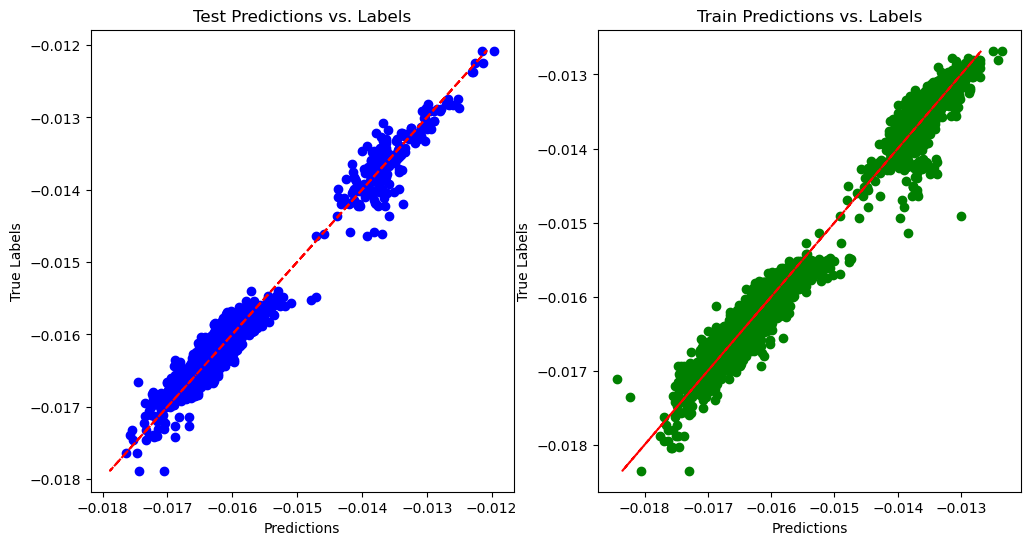

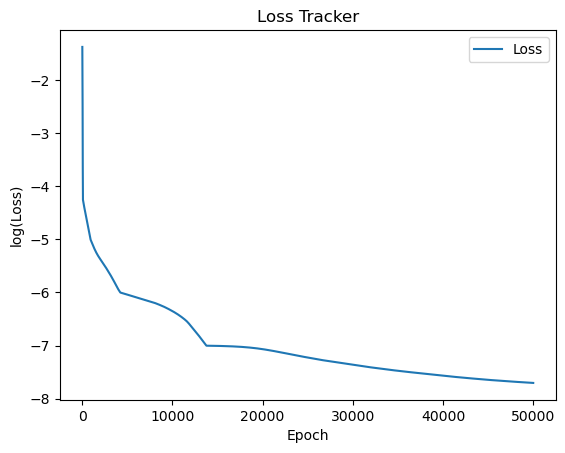

In [11]:
testpredictions=predict(testfeats,testaddfeats)
trainpredictions=predict(trainselffeats,trainselfaddfeats)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot test predictions vs. labels
axs[0].scatter(testpredictions, testselflabels, color='blue', label='Test')
axs[0].plot(testselflabels,testselflabels, color='red',linestyle='--')
axs[0].set_title("Test Predictions vs. Labels")
axs[0].set_xlabel("Predictions")
axs[0].set_ylabel("True Labels")

# Plot train predictions vs. labels
axs[1].scatter(trainpredictions, trainselflabels, color='green', label='Train')
axs[1].plot(trainselflabels,trainselflabels, color='red',linestyle='--')
axs[1].set_title("Train Predictions vs. Labels")
axs[1].set_xlabel("Predictions")
axs[1].set_ylabel("True Labels")

# Display the plots
plt.savefig('self-train-test-50k.png')
plt.show()

# Plot the loss tracker in a new figure
plt.figure()
plt.plot(losstracker.keys(), losstracker.values(), label='Loss')
plt.title("Loss Tracker")
plt.xlabel("Epoch")
plt.ylabel("log(Loss)")
plt.legend()

# Display the loss tracker plot
plt.savefig('self-training-epoch-loss.png')
plt.show()

In [7]:
#Same spin neural network


# Loading "same" labeled training data
trainorbital1density_same = np.load('data/trainorbital1density_same.npy')
trainorbital1other_same = np.load('data/trainorbital1other_same.npy')
trainorbital2density_same = np.load('data/trainorbital2density_same.npy')
trainorbital2other_same = np.load('data/trainorbital2other_same.npy')
traindistance_same = np.load('data/traindistance_same.npy')
trainlabels_same = np.load('data/trainlabels_same.npy')

# Loading "same" labeled test data
testorbital1density_same = np.load('data/testorbital1density_same.npy')
testorbital1other_same = np.load('data/testorbital1other_same.npy')
testorbital2density_same = np.load('data/testorbital2density_same.npy')
testorbital2other_same = np.load('data/testorbital2other_same.npy')
testdistance_same = np.load('data/testdistance_same.npy')
testlabels_same = np.load('data/testlabels_same.npy')





#intepret density and pass to nn2
class orbitalnn1(tf.keras.Model):
    def __init__(self):
        super(orbitalnn1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(640, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(64)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# combines the density with additional information to form a ML compatible orbital object
class orbitalnn2(tf.keras.Model):
    def __init__(self):
        super(orbitalnn2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(320, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(64) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

#takes both of the orbital objects and the distances array to then produces a correlation energy estimate
class correlationNN(tf.keras.Model):
    def __init__(self):
        super(correlationNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(4096, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(1)
        
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

def predict(orbital1density,orbital1other, orbital2density, orbital2other, distances):

    #generate orbital 1
    orbital1nn1=orbinn1_same(orbital1density)
    orbital1nn2_input=tf.concat([orbital1nn1,orbital1other],axis=1)
    orbital1=orbinn2_same(orbital1nn2_input)
    
    #generate orbital 2
    orbital2nn1=orbinn1_same(orbital2density)
    orbital2nn2_input=tf.concat([orbital2nn1,orbital2other],axis=1)
    orbital2=orbinn2_same(orbital2nn2_input)

    #feedforward to obtain the answer
    correlation_input=tf.concat([orbital1nn1,orbital2nn1,distances],axis=1)
    correlation_energy=corrNN_same(correlation_input)
    
    
    return correlation_energy 



orbinn1_same = orbitalnn1()
orbinn2_same = orbitalnn2()
corrNN_same = correlationNN()

# Optimizers
optimizer = tf.keras.optimizers.Adam()

# Loss function
loss_fn = tf.keras.losses.Huber()

losstracker={}

epochs=10000
#batch_size=3024
#batches=len(trainlabels)//batch_size

testloss=0
for epoch in range(epochs):

    with tf.GradientTape() as tape:
        # Generate orbital 1
        orbital1nn1 = orbinn1_same(trainorbital1density_same)
        orbital1nn2_input = tf.concat([orbital1nn1, trainorbital1other_same], axis=1)
        orbital1 = orbinn2_same(orbital1nn2_input)
        
        # Generate orbital 2
        orbital2nn1 = orbinn1_same(trainorbital2density_same)
        orbital2nn2_input = tf.concat([orbital2nn1, trainorbital2other_same], axis=1)
        orbital2 = orbinn2_same(orbital2nn2_input)
    
        # Feedforward to obtain the answer
        correlation_input = tf.concat([orbital1, orbital2, traindistance_same], axis=1)
        correlation_energy = corrNN_same(correlation_input)
    
        # Compute the loss for this batch
        loss = loss_fn(trainlabels_same, correlation_energy)

    # Compute gradients and apply them
    gradients = tape.gradient(loss, orbinn1_same.trainable_variables + orbinn2_same.trainable_variables + corrNN_same.trainable_variables)
    optimizer.apply_gradients(zip(gradients, orbinn1_same.trainable_variables + orbinn2_same.trainable_variables + corrNN_same.trainable_variables))

    
    # At the end of each epoch, evaluate the model on the test set and adjust the learning rate
    if (epoch + 1) % 10 == 0:
        predictions = predict(testorbital1density_same, testorbital1other_same, testorbital2density_same, testorbital2other_same, testdistance_same)
        testloss = loss_fn(testlabels_same, predictions)
        losstracker.update({epoch: math.log10(testloss.numpy())})
        
        # Adjust the learning rate based on the test loss
        if testloss > 10**-3:
            optimizer.learning_rate.assign(0.01)
        elif testloss > 10**-4:
            optimizer.learning_rate.assign(0.005)
        elif testloss > 10**-5:
            optimizer.learning_rate.assign(0.001)
        elif testloss > 10**-6:
            optimizer.learning_rate.assign(0.0005)
        elif testloss > 10**-7:
            optimizer.learning_rate.assign(0.0001)
        elif testloss > 10**-8:
            optimizer.learning_rate.assign(0.000001)

        if epoch%1000==0:
            orbinn1_same.save(f'models/same-noself-orbinn1-{epoch}.h5')
            orbinn1_same.save_weights(f'models/same-noself-orbinn1-{epoch}.weights.h5')
            orbinn2_same.save(f'models/same-noself-orbinn2-{epoch}.h5')
            orbinn2_same.save_weights(f'same-noself-orbinn2-{epoch}.weights.h5')
            corrNN_same.save(f'models/same-noself-orbinn2-{epoch}.h5')
            corrNN_same.save_weights(f'same-noself-orbinn2-{epoch}.weights.h5')
        
    # Print the accumulated epoch loss
    print(f'Epoch {epoch + 1}, Loss: {loss}, Last Test Loss: {testloss}')

Epoch 1, Loss: 2.8446183932828717e-06, Last Test Loss: 0
Epoch 2, Loss: 1.1687433243423584e-06, Last Test Loss: 0
Epoch 3, Loss: 8.59160138588777e-07, Last Test Loss: 0
Epoch 4, Loss: 1.313944721914595e-06, Last Test Loss: 0
Epoch 5, Loss: 1.5980962189132697e-06, Last Test Loss: 0
Epoch 6, Loss: 1.4519607702823123e-06, Last Test Loss: 0
Epoch 7, Loss: 1.1058975815103622e-06, Last Test Loss: 0
Epoch 8, Loss: 8.283120109808806e-07, Last Test Loss: 0
Epoch 9, Loss: 7.575610538879118e-07, Last Test Loss: 0
Epoch 10, Loss: 8.637898076813144e-07, Last Test Loss: 1.0256384257445461e-06
Epoch 11, Loss: 1.0028138603956904e-06, Last Test Loss: 1.0256384257445461e-06
Epoch 12, Loss: 1.0218536772299558e-06, Last Test Loss: 1.0256384257445461e-06
Epoch 13, Loss: 9.801906344364397e-07, Last Test Loss: 1.0256384257445461e-06
Epoch 14, Loss: 8.969189480012574e-07, Last Test Loss: 1.0256384257445461e-06
Epoch 15, Loss: 8.005029030755395e-07, Last Test Loss: 1.0256384257445461e-06
Epoch 16, Loss: 7.1783

In [8]:
orbinn1_same.save(f'models/same-noself-orbinn1-final.h5')
orbinn1_same.save_weights(f'models/same-noself-orbinn1-final.weights.h5')
orbinn2_same.save(f'models/same-noself-orbinn2-final.h5')
orbinn2_same.save_weights(f'models/same-noself-orbinn2-final.weights.h5')
corrNN_same.save(f'models/same-noself-corrNN-final.h5')
corrNN_same.save_weights(f'models/same-noself-corrNN-final.weights.h5')

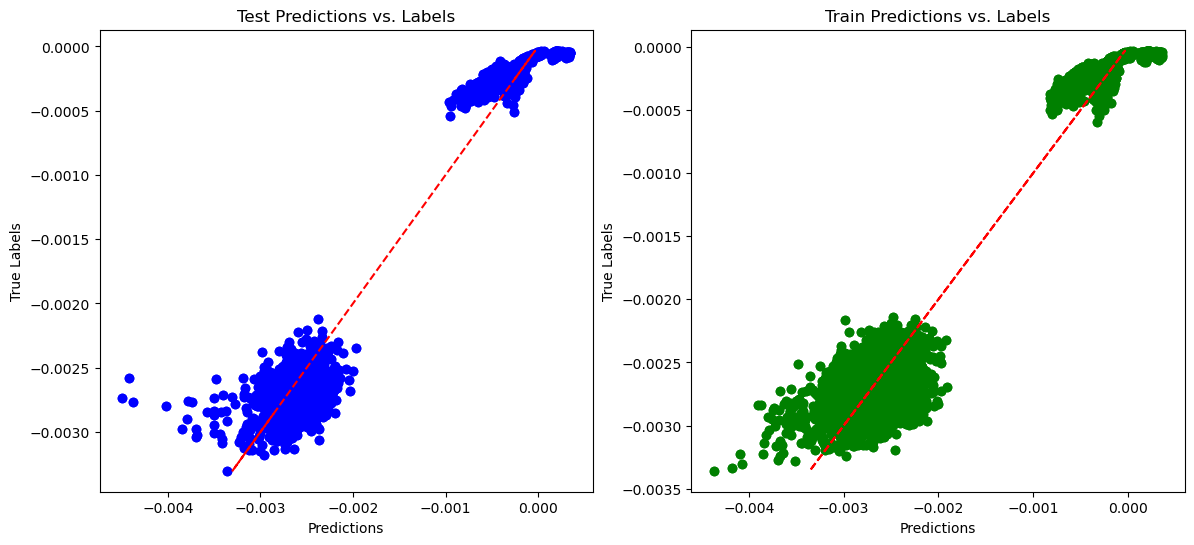

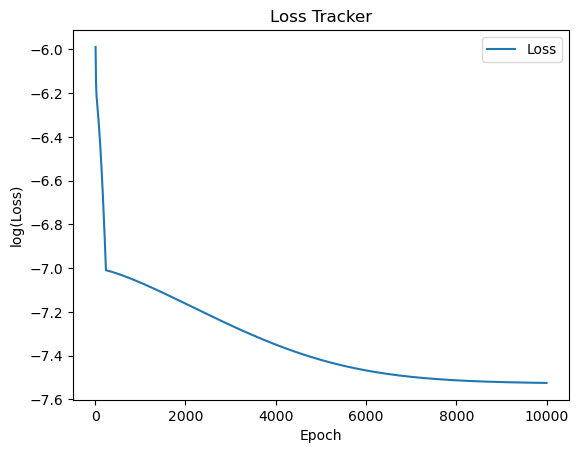

In [11]:
testpredictions=predict(testorbital1density_same,testorbital1other_same,testorbital2density_same,testorbital2other_same ,testdistance_same)
trainpredictions=predict(trainorbital1density_same,trainorbital1other_same,trainorbital2density_same,trainorbital2other_same,traindistance_same)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot test predictions vs. labels
axs[0].scatter(testpredictions, testlabels_same, color='blue', label='Test')
axs[0].plot(testlabels_same,testlabels_same, color='red',linestyle='--')
axs[0].set_title("Test Predictions vs. Labels")
axs[0].set_xlabel("Predictions")
axs[0].set_ylabel("True Labels")

# Plot train predictions vs. labels
axs[1].scatter(trainpredictions, trainlabels_same, color='green', label='Train')
axs[1].plot(trainlabels_same,trainlabels_same, color='red',linestyle='--')
axs[1].set_title("Train Predictions vs. Labels")
axs[1].set_xlabel("Predictions")
axs[1].set_ylabel("True Labels")

# Display the plots
plt.savefig('noself-train-test-10k.png')
plt.show()

# Plot the loss tracker in a new figure
plt.figure()
plt.plot(losstracker.keys(), losstracker.values(), label='Loss')
plt.title("Loss Tracker")
plt.xlabel("Epoch")
plt.ylabel("log(Loss)")
plt.legend()

# Display the loss tracker plot
plt.savefig('noself-training-epoch-loss.png')
plt.show()